In [25]:
import pandas as pd
import numpy as np
import itertools

Q = 1.0
T = 1.0

class Game(object):
    def __init__(self,df):
        self.df = df                                  #df = dataframe
        self.df_capability = df.Capability.to_dict()    
        self.df_position = df.Position.to_dict()    
        self.df_salience = df.Salience.to_dict()    
        self.max_pos = df.Position.max()
        self.min_pos = df.Position.min()

    def weighted_median(self):
        self.df['w'] = self.df.Capability*self.df.Salience 
        self.df['w'] = self.df['w'] / self.df['w'].sum()
        self.df['w'] = self.df['w'].cumsum()
        return float(self.df[self.df['w']>=0.5].head(1).Position)

    def mean(self):
        return (self.df.Capability*self.df.Position*self.df.Salience).sum() / \
               (self.df.Capability*self.df.Salience).sum()

    def Usi_i(self,i,j,ri=1.):
        tmp1 = self.df_position[i]-self.df_position[j]
        tmp2 = self.max_pos-self.min_pos
        return 2. - 4.0 * ( (0.5-0.5*np.abs(float(tmp1)/tmp2) )**ri)

    def Ufi_i(self,i,j,ri=1.):
        tmp1 = self.df_position[i]-self.df_position[j]
        tmp2 = self.df.Position.max()-self.df.Position.min()
        return 2. - 4.0 * ( (0.5+0.5*np.abs(float(tmp1)/tmp2) )**ri )

    def Usq_i(self,i,ri=1.):
        return 2.-(4.*(0.5**ri))

    def Ui_ij(self,i,j):
        tmp1 = self.df_position[i] - self.df_position[j]
        tmp2 = self.max_pos-self.min_pos
        return 1. - 2.*np.abs(float(tmp1) / tmp2) 

    def v(self,i,j,k):
        return self.df_capability[i]*self.df_salience[i]*(self.Ui_ij(i,j)-self.Ui_ij(i,k)) 

    def Pi(self,i):
        l = np.array([[i,j,k] for (j,k) in itertools.combinations(range(len(self.df)), 2 ) if i!=j and i!=k])
        #U_filter = np.array(map(lambda i,j,k: self.Ui_ij(j,i)>self.Ui_ij(i,k), l))
        U_filter = [self.Ui_ij(j,i)>self.Ui_ij(i,k) for i, j, k in l]
        lpos = l[U_filter]
        #tmp1 = np.sum(map(lambda i,j,k: self.v(j,i,k), lpos))
        #tmp2 = np.sum(map(lambda i,j,k: self.v(j,i,k), l))
        tmp1 = np.sum([self.v(j,i,k) for i, j, k in lpos])
        tmp2 = np.sum([self.v(j,i,k) for i, j, k in l])
        return float(tmp1)/tmp2

    def Ubi_i(self,i,j,ri=1):
        tmp1 = np.abs(self.df_position[i] - self.weighted_median()) + \
               np.abs(self.df_position[i] - self.df_position[j])
        tmp2 = np.abs(self.max_pos-self.min_pos)
        return 2. - (4. * (0.5 - (0.25 * float(tmp1) / tmp2))**ri)

    def Uwi_i(self,i,j,ri=1):
        tmp1 = np.abs(self.df_position[i] - self.weighted_median()) + \
               np.abs(self.df_position[i] - self.df_position[j])
        tmp2 = np.abs(self.max_pos-self.min_pos)
        return 2. - (4. * (0.5 + (0.25 * float(tmp1) / tmp2))**ri)

    def EU_i(self,i,j,r=1):
        term1 = self.df_salience[j] * \
                ( self.Pi(i)*self.Usi_i(i,j,r) + ( 1.-self.Pi(i) )*self.Ufi_i(i,j,r) )
        term2 = (1-self.df_salience[j])*self.Usi_i(i,j,r)
        #term3 = -self.Qij(j,i)*self.Usq_i(i,r)
        #term4 = -(1.-self.Qij(j,i))*( T*self.Ubi_i(i,j,r) + (1.-T)*self.Uwi_i(i,j,r) )
        term3 = -Q*self.Usq_i(i,r)
        term4 = -(1.-Q)*( T*self.Ubi_i(i,j,r) + (1.-T)*self.Uwi_i(i,j,r) )
        return term1+term2+term3+term4

    def EU_j(self,i,j,r=1):
        return self.EU_i(j,i,r)

    def Ri(self,i):
        # get all j's except i
        l = [x for x in range(len(self.df)) if x!= i]
        #tmp = np.array(list(map(lambda x: self.EU_j(i,x), l)))
        tmp = np.array([self.EU_j(i,x) for x in l])
        numterm1 = 2 * np.sum(tmp)
        numterm2 = (len(self.df)-1)*np.max(tmp)
        numterm3 = (len(self.df)-1)*np.min(tmp)
        return float(numterm1-numterm2-numterm3) / (numterm2-numterm3)

    def ri(self,i):
        Ri_tmp = self.Ri(i)
        return (1-Ri_tmp/3.) / (1+Ri_tmp/3.)

    def Qij(self,i,j):
        l = np.array([k for k in range(len(self.df))])
        res = map(lambda x: self.Pi(k)+(1-self.df_salience[k]),l)
        return np.product(res)

    def calc_offer(self, x):
        if len(x)>0:
            return x[np.argmin(np.abs(x))]
        return 0

    def do_round(self,df):
        self.df = df; df_new = self.df.copy()        
        # reinit
        self.df_capability = self.df.Capability.to_dict()    
        self.df_position = self.df.Position.to_dict()    
        self.df_salience = self.df.Salience.to_dict()    
        self.max_pos = self.df.Position.max()
        self.min_pos = self.df.Position.min()

        offers = [list() for i in range(len(self.df))]
        ris = [self.ri(i) for i in range(len(self.df))]
        for (i,j) in itertools.combinations(range(len(self.df)), 2 ):
            eui = self.EU_i(i,j,r=ris[i])
            euj = self.EU_j(i,j,r=ris[j])
            if eui > 0 and euj > 0:
                # conflict
                mid_step = (self.df_position[i]-self.df_position[j])/2.
                print(i,j,eui,euj,'conflict, both step', mid_step, -mid_step)
                offers[j].append(mid_step)
                offers[i].append(-mid_step)
            elif eui > 0 and euj < 0 and np.abs(eui) > np.abs(euj):
                # compromise - actor i has the upper hand
                print(i,j,eui,euj,'compromise', i, 'upper hand')
                xhat = (self.df_position[i]-self.df_position[j]) * np.abs(euj/eui)
                offers[j].append(xhat)
            elif eui < 0 and euj > 0 and np.abs(eui) < np.abs(euj):
                # compromise - actor j has the upper hand
                print(i,j,eui,euj,'compromise', j, 'upper hand')
                xhat = (self.df_position[j]-self.df_position[i]) * np.abs(eui/euj)
                offers[i].append(xhat)
            elif eui > 0 and euj < 0 and np.abs(eui) < np.abs(euj):
                # capinulation - actor i has upper hand
                j_moves = self.df_position[i]-self.df_position[j]
                print(i,j,eui,euj,'capitulate', i, 'wins', j, 'moves',j_moves)
                offers[j].append(j_moves)
            elif eui < 0 and euj > 0 and np.abs(eui) > np.abs(euj):
                # capitulation - actor j has upper hand
                i_moves = self.df_position[j]-self.df_position[i]
                print(i,j,eui,euj,'capitulate', j, 'wins', i, 'moves',i_moves)
                offers[i].append(i_moves)
            else:
                print(i,j,eui,euj,'nothing')

        print(offers)
        #df_new['offer'] = map(lambda x: 0 if len(x)==0 else x[np.argmin(np.abs(x))],offers)
        df_new['offer'] = [self.calc_offer(x) for x in offers]
        df_new['Position'] = df_new['Position'] + df_new.offer
        df_new.loc[df_new['Position']>self.max_pos,'Position'] = self.max_pos
        df_new.loc[df_new['Position']<self.min_pos,'Position'] = self.min_pos
        return df_new


In [26]:
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
%matplotlib inline

In [53]:
#df = pd.read_csv('actors_WW1.csv', sep=',')
#df = pd.read_csv('actors_Columbus.csv', sep=',')
#df = pd.read_csv('actors_Zene1.csv', sep=',')
#df = pd.read_csv('actors_Zene3.csv', sep=',')
#df = pd.read_excel(r'c:\Dropbox\Game Theory\Matlab\BDM\Zenekar.xlsx', 1)
df = pd.read_excel(r'c:\Dropbox\Game Theory\Matlab\BDM\Predictioneers_Game.xlsx', 3)    #1:WW1_BDM, 2:WW1_mod
df.dtypes
df.Position = df.Position.astype(float)
df.Capability = df.Capability.astype(float)
#df.Salience = df.Salience/100.0
df.Salience = df.Salience
df.head()

,Actor,Capability,Position,Salience
0,AUH,68.0,1.00,0.95
1,GER,158.0,0.90,0.75
2,ITA,26.0,0.95,0.60
3,FRN,75.0,0.45,0.70
4,RUS,111.0,0.40,1.00


In [54]:
game = Game(df)

results = pd.DataFrame(index=df.index)
for i in range(10):
    results[i] = df.Position
    df = game.do_round(df)
    print(df)
    print('weighted_median', game.weighted_median(), 'mean', game.mean())

results =  results.T
results.columns = df.Actor
print(results)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:51: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


0 1 -1.80898724366 -2.83501118755 nothing
0 2 -0.703801944908 0.888811886274 compromise 2 upper hand
0 3 -9.2208815928 -14.8936015116 nothing
0 4 -14.8893438747 -52.6282543033 nothing
0 5 -16.1357859189 46.0113054186 compromise 5 upper hand
0 6 -23.628717791 7.13839068131 capitulate 6 wins 0 moves -1.0
0 7 -1.67516156244 -0.292544119506 nothing
0 8 -17.7384027151 14.2561072648 capitulate 8 wins 0 moves -0.8
0 9 -9.05078555172 -8.8880810296 nothing
0 10 -4.52258418113 -2.00243385267 nothing
1 2 -0.858746203247 0.722586859562 capitulate 2 wins 1 moves 0.05
1 3 -9.16985868284 -9.4242137332 nothing
1 4 -14.986525186 -34.3872296979 nothing
1 5 -16.4893938548 30.9875777003 compromise 5 upper hand
1 6 -25.635372164 5.47069825965 capitulate 6 wins 1 moves -0.9
1 7 0.0 -6.93889390391e-18 nothing
1 8 -18.7671142199 10.1695783782 capitulate 8 wins 1 moves -0.7
1 9 -8.78882271207 -5.44594948947 nothing
1 10 -3.29456588567 -0.885653212215 nothing
2 3 6.82446232394 -8.1798801777 capitulate 2 wins 3 

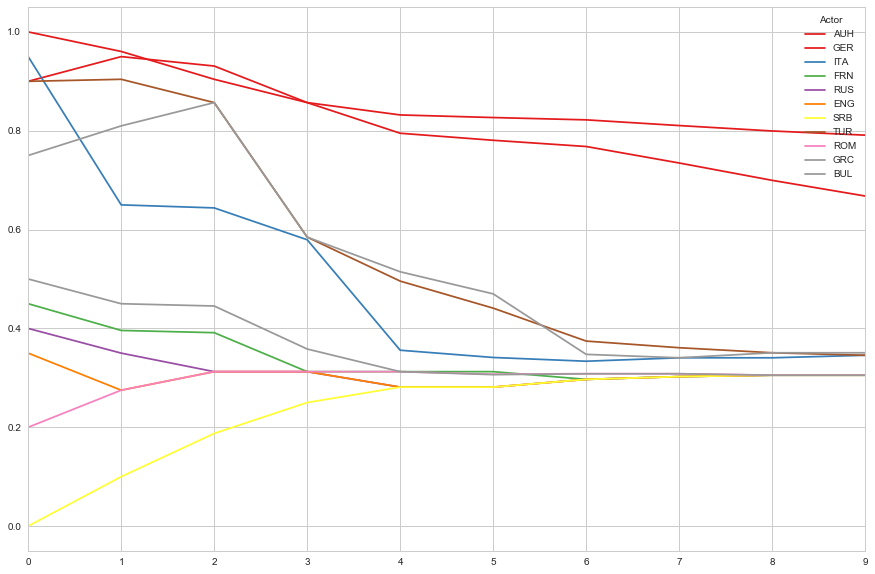

In [55]:
plt.style.use('seaborn-whitegrid')
results.plot(figsize=(15,10), colormap='Set1')